# 1. Virtual Repository

In [6]:
# Setting up the virtual directory
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [7]:
# Root directory
# YOU CHANGED THIS
ROOT_DIR = ""

# Utility directories
MODELS_DIR  = ROOT_DIR + "models/"
BACKUPS_DIR = ROOT_DIR + "backups/"
DATA_DIR    = ROOT_DIR + "data/"

# 2. Dependencies

In [8]:
# Dependencies
import tensorflow as tf
import keras
from keras.models import Model, save_model, load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
import numpy as np
import math

# Random seed
RANDOM_STATE = 11

# Stylization of 2 graphics
plt.style.use("bmh")

In [9]:
# Check if the GPU is being used and apply to memory expansion
physical_devices = tf.config.experimental.list_physical_devices("GPU")
# YOU CHANGED THIS
print("Quantitiy of GPUs available:", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Quantitiy of GPUs available: 0


IndexError: list index out of range

# 3. Data Generator

In [10]:
# To speed up processing
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize

class LungCancerDataGenerator(Sequence):
    '''
    Data generator from set annotations
    of data for predicting tumors in images
    lung radiographs.
    '''
    def __init__(
            self,
            df,
            data_directory_path,
            batch_size=64,
            input_shape=(512, 512, 3),
            shuffle=True,
            map=None
        ):
        '''
        Parameters:
        ----------
        df: DataFrame
            Table containing the dataset annotations.
            It must contain the columns "patient", "image", "xmin",
            "ymin", "xmax", "ymax" and "class".
        data_directory_path: str
            Path to the data directory.
        batch_size: int, default=128
            Desired size for data batches.
        input_shape: tuple[3], default = (512, 512, 3)
            Format of input tensors.
        shuffle: bool, default=True
            Indicates whether or not to shuffle the tuples
            at the end of the era.
        map: function, default=None
            Image processing function.
        '''
        # Cópia do conjunto de dados
        self.df = df.copy()

        # Aquisição dos nomes de arquivo
        self.df["filename"] = df.patient_id + "/" + df.image_path.astype("str") + ".jpg"
        self.df.drop(axis=1, labels=["patient_id", "image_path"], inplace=True)

        # Normalização da bounding box
        self.df.xmin /= input_shape[0]
        self.df.xmax /= input_shape[1]
        self.df.ymin /= input_shape[0]
        self.df.ymax /= input_shape[1]

        # Mapeamento das classes para inteiros
        self.df["class"] = self.df["class"].map({
            label:idx for idx, label in enumerate(
                self.df["class"].unique()
            )
        })

        # Caminho para o diretório contendo os dados
        self.data_directory_path = data_directory_path
        if self.data_directory_path[-1] != '/':
            self.data_directory_path = self.data_directory_path + '/'

        # Função de mapeamento das imagens
        if map is None:
            map = lambda x: x
        self.map = map

        # Demais informações
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.shuffle = shuffle
        self.num_samples = len(self.df)
        self.num_labels = self.df["class"].nunique()


    def __len__(self):
        ''' Retorna a quantia de batches que o gerador pode produzir '''
        return math.ceil(self.num_samples / self.batch_size)


    def on_epoch_end(self):
        '''
        Embaralha o conjunto de dados a cada finalização
        de época caso tal opção esteja ativa
        '''
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


    def _load_image(self, data):
        ''' Carrega e pré-processa uma imagem com base numa tupla de dados '''

        # Carregamento da imagem
        # Obs.: "rgb", pois "grayscale" tem problema de canais com as redes pré-treinadas
        img = load_img(self.data_directory_path + data.filename, color_mode="rgb")
        img = img_to_array(img)

        # Reescala e normalização
        img = resize(img, (self.input_shape[0], self.input_shape[1])).numpy()
        img = img/255.0

        return img


    def _get_output(self, data):
        ''' Retorna o valor de saída da instância '''

        # Bounding box
        xmin = data.xmin
        ymin = data.ymin
        xmax = data.xmax
        ymax = data.ymax
        bbox = np.array([xmin, ymin, xmax, ymax])

        # Classe
        label = data["class"]
        label = to_categorical(label, self.num_labels)

        # Junção
        return [bbox, label]


    def __getitem__(self, index):
        ''' Gera um batch de dados '''
        batches = self.df[index*self.batch_size: (index+1)*self.batch_size]
        X = self.map(np.array([self._load_image(row) for _, row in batches.iterrows()]))
        y = np.array([self._get_output(row) for _, row in batches.iterrows()])
        y = {"bbox": y[:,0,:], "label": y[:,1,:]}
        return X, y

# 4. Loading and splitting data

In [11]:
# Image annotations
import pandas as pd
annotations = pd.read_csv(DATA_DIR + "annotations.csv")
annotations.tail()

,patient_id,image_path,xmin,ymin,xmax,ymax,class
3292,G0062,5,293,328,373,402,G
3293,G0062,6,310,334,371,403,G
3294,G0062,7,304,336,362,386,G
3295,G0062,8,291,326,369,382,G
3296,G0062,9,294,323,367,400,G


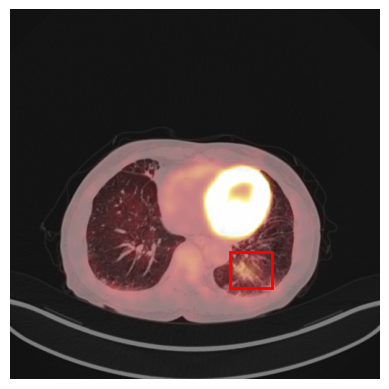

In [12]:
def display_sample_image(sample):
    ''' Plots the image referring to an instance of the data '''
    # YOU CHANGED THIS
    img = Image.open(DATA_DIR + sample.patient_id + "/" + str(sample.image_path) + '.jpg')
    fig, ax = plt.subplots()
    ax.imshow(img)
    rect = patches.Rectangle(
        (sample.xmin, sample.ymin),
        sample.xmax-sample.xmin,
        sample.ymax-sample.ymin,
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)
    ax.axis("off")
    plt.grid(False)
    plt.show()

# Viewing an instance of data
sample = annotations.iloc[-3]
display_sample_image(sample)

Observação: tem-se as seguintes classes:

- A = Adenocarcinoma

- B = Small Cell Carcinoma

- E = Large Cell Carcinoma

- G = Squamous Cell Carcinoma


,patient_id
class,
A,2303
B,355
E,44
G,595


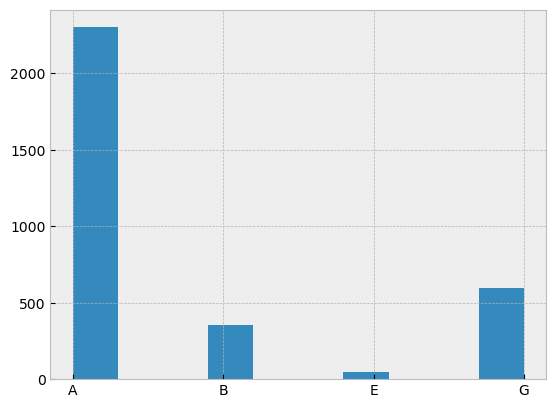

In [13]:
# Distribution of classes
annotations["class"].hist()
# YOU CHANGED THIS
pd.DataFrame(annotations.groupby("class").patient_id.count())

In [14]:
# Splitting the data
X = annotations.drop(axis=1, labels=["class"])
y = annotations["class"]

# Stratified holdout (no computational power for k-folds)
# 80% for training, 10% for validation, 10% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=RANDOM_STATE, stratify=y_train)

# Data generator
train_data_generator = LungCancerDataGenerator(pd.concat([X_train, y_train], axis=1), DATA_DIR)
test_data_generator = LungCancerDataGenerator(pd.concat([X_test, y_test], axis=1), DATA_DIR)
val_data_generator = LungCancerDataGenerator(pd.concat([X_val, y_val], axis=1), DATA_DIR)

# 5. Model Training

## 5.1. General Dependencies

In [15]:
# Epoch control
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Optimizers
from keras.optimizers.legacy import Adam, SGD

# Layers
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Original models
from keras.applications.xception import Xception
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3

# For image pre-processing
from keras.applications.xception import preprocess_input as xception_preprocess_input
from keras.applications.resnet import preprocess_input as resnet_preprocess_input
from keras.applications.inception_v3 import preprocess_input as inception_preprocess_input

# For mapping
XCEPTION = "xception"
RESNET50 = "resnet"
INCEPTIONV3 = "inception"
results = {}

# Paths to save models
model_paths = {
    XCEPTION: MODELS_DIR + "xception_model.h5",
    RESNET50: MODELS_DIR + "resnet50_model.h5",
    INCEPTIONV3: MODELS_DIR + "inceptionv3_model.h5",
}

# Input tensor
input_tensor = keras.layers.Input(shape=(512, 512, 3))


# Stop generator
get_early_stopping = lambda patience=6: EarlyStopping (
    monitor='loss',
    min_delta=0,
    patience=patience,
    verbose=2,
    mode='auto'
)


# Create checkpoint backups
get_checkpointer = lambda model_name: ModelCheckpoint (
    filepath = BACKUPS_DIR + model_name + '.{epoch:02d}.hdf5',
    verbose=2,
    save_best_only=True,
    save_weights_only=True
)


def get_detector_model(base_model, num_classes=4):
    '''
    From a base model, returns a model
    bounding box and class predictor for prediction
    of tumors on lung x-rays
    '''

    # Base Model Output Processing
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Function 1: bounding box
    bbox = Dense(128, activation='relu')(x)
    bbox = Dense(64, activation='relu')(bbox)
    bbox = Dense(32, activation='relu')(bbox)
    bbox_output = Dense(4, activation='sigmoid', name="bbox")(bbox)

    # Function 2: class prediction
    label = Dense(512, activation="relu")(x)
    label = Dropout(0.5)(label)
    label = Dense(512, activation="relu")(label)
    label = Dropout(0.5)(label)
    label_output = Dense(num_classes, activation="softmax", name="label")(label)

    # New model
    detector_model = Model(inputs=base_model.input, outputs=(bbox_output, label_output))

    # Freezing the convolutional layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Compilation
    detector_model.compile (
        optimizer = Adam(learning_rate = 0.00025, clipnorm = 1.0),
        metrics = {
            "label": "accuracy",
	        "bbox": "mse",
        },
        loss = {
            "label": "categorical_crossentropy",
	        "bbox": "mean_squared_error",
        },
        loss_weights = {
	        "label": 1.0,
	        "bbox": 1.0
        }
    )

    return detector_model


class ModelTrainer:
    ''' Class used to train the models '''

    def __init__(self, model, train_data_gen, test_data_gen, early_stopping, checkpointer):
        ''' Storing boot information '''
        self.model = model
        self.train_data_gen = train_data_gen
        self.test_data_gen = test_data_gen
        self.early_stopping = early_stopping
        self.checkpointer = checkpointer


    def _train_model(self, epochs):
        ''' Model training '''
        return self.model.fit (
            self.train_data_gen,
            validation_data = self.test_data_gen,
            epochs = epochs,
            callbacks=[self.early_stopping, self.checkpointer]
        )


    def _recompile_model(self):
        ''' Recompiles the bounding box prediction model after training its upper layers '''
        self.model.compile (
            optimizer = SGD(learning_rate=0.0001, momentum=0.9),
            metrics = {
                "label": [
                    "accuracy",
                    keras.metrics.Precision(name="precision"),
                    keras.metrics.Recall(name="recall"),
                ],
                "bbox": "mse"
            },
            loss = {
                "label": "categorical_crossentropy",
                "bbox": "mean_squared_error",
            },
            loss_weights = {
                "label": 1.0,
                "bbox": 1.0
            }
        )


    def _plot_common_graphs(self, epochs, history, ax):
        ''' Prepares the plot of graphs common to both training sessions '''

        # Label Loss
        ax[0].plot(epochs, history['label_loss'], label="train")
        ax[0].plot(epochs, history['val_label_loss'], label="val")
        ax[0].set_title('Label Loss')
        ax[0].set_xlabel("epoch")
        ax[0].legend()

        # BBox Loss
        ax[1].plot(epochs, history['bbox_loss'], label="train")
        ax[1].plot(epochs, history['val_bbox_loss'], label="val")
        ax[1].set_title('BBox Loss')
        ax[1].set_xlabel("epoch")
        ax[1].legend()

        # Label accuracy
        ax[2].plot(epochs, history['label_accuracy'], label="train")
        ax[2].plot(epochs, history['val_label_accuracy'], label="val")
        ax[2].set_title('Label Accuracy')
        ax[2].set_xlabel("epoch")
        ax[2].legend()

        # BBox MSE
        ax[3].plot(epochs, history['bbox_mse'], label="train")
        ax[3].plot(epochs, history['val_bbox_mse'], label="val")
        ax[3].set_title('BBox MSE')
        ax[3].set_xlabel("epoch")
        ax[3].legend()


    def first_train(self, epochs=4):
        ''' Performs the first model training '''

        # Training and background acquisition
        history = self._train_model(epochs)

        # Number of epochs passed
        num_epochs = len(history.history['loss'])
        epochs = np.arange(num_epochs)
        history = history.history

        # Number of epochs passed
        num_epochs = len(history['loss'])
        epochs = np.arange(num_epochs)

        # Figure size
        fig, ax = plt.subplots(1,4,figsize=(16,4))

        # Graphics
        self._plot_common_graphs(epochs, history, ax)

        # Finalizing
        plt.show()
        return history


    def second_train(self, epochs=16):
        ''' Performs the second training of the model '''

        # Recompile the model
        self._recompile_model()

        # Training & background acquisition
        history = self._train_model(epochs)

        # Number of epochs passed
        num_epochs = len(history.history['loss'])
        epochs = np.arange(num_epochs)
        history = history.history

        # Number of epochs passed
        num_epochs = len(history['loss'])
        epochs = np.arange(num_epochs)

        # Figure size
        fig, ax = plt.subplots(1,6,figsize=(24,4))

        # Graphics
        self._plot_common_graphs(epochs, history, ax)

        # Accuracy graph
        ax[4].plot(epochs, history['label_precision'], label="train")
        ax[4].plot(epochs, history['val_label_precision'], label="val")
        ax[4].set_title('Label Precision')
        ax[4].set_xlabel("epoch")
        ax[4].legend()

        # Recall graph
        ax[5].plot(epochs, history['label_recall'], label="train")
        ax[5].plot(epochs, history['val_label_recall'], label="val")
        ax[5].set_title('Label Recall')
        ax[5].set_xlabel("epoch")
        ax[5].legend()

        # Plotting
        plt.show()


def display_prediction_on_sample_image(model, generator, sample_idx):
    ''' Plota a imagem referente a uma instância dos dados, mostrando a predição do modelo '''

    # Processamento da tupla de dados
    data = generator.df.iloc[sample_idx]
    X = generator.map(generator._load_image(data)).reshape((1,512,512,3))

    # Predição
    labels = ["A", "B", "E", "G"]
    bbox, label = np.mean(model(X), axis=1)
    bbox = np.array(bbox*512, dtype="int")
    label = labels[np.argmax(label)]

    # Plotagem da imagem
    img = Image.open(generator.data_directory_path + data.filename)
    fig, ax = plt.subplots()
    ax.imshow(img)

    # Retângulo da predição
    pred_rect = patches.Rectangle(
        (bbox[0], bbox[1]),
        bbox[2]-bbox[0],
        bbox[3]-bbox[1],
        linewidth=2,
        edgecolor='r',
        facecolor='none',
        label="predicted: " + label
    )
    ax.add_patch(pred_rect)

    # Retângulo original
    bbox = np.array([data.xmin, data.ymin, data.xmax, data.ymax])
    bbox = np.array(bbox*512, dtype="int")
    rect = patches.Rectangle(
        (bbox[0], bbox[1]),
        bbox[2]-bbox[0],
        bbox[3]-bbox[1],
        linewidth=1,
        edgecolor='b',
        facecolor='none',
        label="ground-truth: " + labels[data["class"]]
    )
    ax.add_patch(rect)

    # Ajustes e plotagem final
    ax.axis("off")
    ax.legend(loc='upper right')
    plt.grid(False)
    plt.show()

## 5.2. Xception

In [16]:
# Obtaining the model
base_model = Xception(input_tensor=input_tensor, weights='imagenet', include_top=False)
xception_model = get_detector_model(base_model)

# Modifying data generators
train_data_generator.map = xception_preprocess_input
test_data_generator.map = xception_preprocess_input
val_data_generator.map = xception_preprocess_input

# For epoch control
early_stopping = get_early_stopping()
checkpointer = get_checkpointer("xception")

# Training class
trainer = ModelTrainer(
    xception_model,
    train_data_generator,
    val_data_generator,
    early_stopping,
    checkpointer
)

In [17]:
# Treino das camadas superiores :: menos épocas aqui
# WARNING: No such file or directory: '/content/drive/My Drive/LungModel/data/A0008/1.jpg'
print("Primeiro treinamento\n")
train_history = trainer.first_train(epochs=6)

# Descongelamento das primeiras camadas
for layer in xception_model.layers[:105]:
   layer.trainable = False
for layer in xception_model.layers[105:]:
   layer.trainable = True

# Treino definitivo :: mais épocas aqui
print("\n\nSegundo treinamento\n")
train_history = trainer.second_train(epochs=24)

Primeiro treinamento

Epoch 1/6
42/42 [==============================] - ETA: 0s - loss: 0.9742 - bbox_loss: 0.0195 - label_loss: 0.9547 - bbox_mse: 0.0195 - label_accuracy: 0.6686
Epoch 1: val_loss improved from inf to 1.90330, saving model to backups/xception.01.hdf5
42/42 [==============================] - 334s 8s/step - loss: 0.9742 - bbox_loss: 0.0195 - label_loss: 0.9547 - bbox_mse: 0.0195 - label_accuracy: 0.6686 - val_loss: 1.9033 - val_bbox_loss: 0.0173 - val_label_loss: 1.8860 - val_bbox_mse: 0.0173 - val_label_accuracy: 0.1818
Epoch 2/6
27/42 [==================>...........] - ETA: 1:38 - loss: 0.8908 - bbox_loss: 0.0186 - label_loss: 0.8723 - bbox_mse: 0.0186 - label_accuracy: 0.7066

KeyboardInterrupt: 

In [ ]:
# Teste
results[XCEPTION] = xception_model.evaluate(test_data_generator)

In [ ]:
# Plota uma solução encontrada
display_prediction_on_sample_image(xception_model, test_data_generator, -1)

In [ ]:
# Salvamento definitivo do modelo
save_model(xception_model, model_paths[XCEPTION])

## 5.3. ResNet50

In [18]:
# Obtenção do modelo
base_model = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
resnet50_model = get_detector_model(base_model)

# Modificação dos geradores de dados
train_data_generator.map = resnet_preprocess_input
test_data_generator.map = resnet_preprocess_input
val_data_generator.map = resnet_preprocess_input

# Para controle de época
early_stopping = get_early_stopping()
checkpointer = get_checkpointer("xception")

# Classe de treinamento
trainer = ModelTrainer(
    resnet50_model,
    train_data_generator,
    val_data_generator,
    early_stopping,
    checkpointer
)

In [19]:
# Treino das camadas superiores :: menos épocas aqui
print("Primeiro treinamento\n")
train_history = trainer.first_train(epochs=6)

# Descongelamento das primeiras camadas
for layer in resnet50_model.layers[:154]:
   layer.trainable = False
for layer in resnet50_model.layers[154:]:
   layer.trainable = True

# Treino definitivo :: mais épocas aqui
print("\n\nSegundo treinamento\n")
train_history = trainer.second_train(epochs=24)

Primeiro treinamento

Epoch 1/6
42/42 [==============================] - ETA: 0s - loss: 1.1561 - bbox_loss: 0.0206 - label_loss: 1.1355 - bbox_mse: 0.0206 - label_accuracy: 0.6196
Epoch 1: val_loss improved from inf to 1.89713, saving model to backups/xception.01.hdf5
42/42 [==============================] - 311s 7s/step - loss: 1.1561 - bbox_loss: 0.0206 - label_loss: 1.1355 - bbox_mse: 0.0206 - label_accuracy: 0.6196 - val_loss: 1.8971 - val_bbox_loss: 0.0178 - val_label_loss: 1.8793 - val_bbox_mse: 0.0178 - val_label_accuracy: 0.1818
Epoch 2/6
26/42 [=================>............] - ETA: 1:46 - loss: 0.9422 - bbox_loss: 0.0193 - label_loss: 0.9229 - bbox_mse: 0.0193 - label_accuracy: 0.6838

KeyboardInterrupt: 

In [ ]:
# Teste
results[RESNET50] = resnet50_model.evaluate(test_data_generator)

In [ ]:
# Plota uma solução encontrada
display_prediction_on_sample_image(resnet50_model, test_data_generator, -1)

In [ ]:
# Salvamento definitivo do modelo
save_model(resnet50_model, model_paths[RESNET50])

## 5.4. InceptionV3

In [ ]:
# Obtenção do modelo
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
inceptionv3_model = get_detector_model(base_model)

# Modificação dos geradores de dados
train_data_generator.map = inception_preprocess_input
test_data_generator.map = inception_preprocess_input
val_data_generator.map = inception_preprocess_input

# Para controle de época
early_stopping = get_early_stopping(patience=16)
checkpointer = get_checkpointer("xception")

# Classe de treinamento
trainer = ModelTrainer(
    inceptionv3_model,
    train_data_generator,
    val_data_generator,
    early_stopping,
    checkpointer
)

In [ ]:
# Treino das camadas superiores :: menos épocas aqui
print("Primeiro treinamento\n")
train_history = trainer.first_train(epochs=24)

# Descongelamento das primeiras camadas
for layer in inceptionv3_model.layers[:249]:
   layer.trainable = False
for layer in inceptionv3_model.layers[249:]:
   layer.trainable = True

# Treino definitivo :: mais épocas aqui
print("\n\nSegundo treinamento\n")
train_history = trainer.second_train(epochs=36)

In [ ]:
# Teste
results[INCEPTIONV3] = inceptionv3_model.evaluate(test_data_generator)

In [ ]:
# Plota uma solução encontrada
display_prediction_on_sample_image(inceptionv3_model, test_data_generator, -1)

In [ ]:
# Salvamento definitivo do modelo
save_model(inceptionv3_model, model_paths[INCEPTIONV3])